## [Link to all chapters](https://www.kaggle.com/ustcer1984/statistics-with-python-for-data-science)

In [1]:
%pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import scikitplot as skplt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

import warnings
warnings.filterwarnings('ignore')

input_path = '/kaggle/input/practical-statistics-with-python-for-data-science/'
loan_data = pd.read_csv(input_path + 'loan_data.csv')
loan3000 = pd.read_csv(input_path + 'loan3000.csv')
full_train_set = pd.read_csv(input_path + 'full_train_set.csv')

# 5 Classification

## 5.1 Naive Bayes

#### <center>Key Terms for Naive Bayes</center>
- ***Conditional probability***  
The probability of observing some event (say, $X = i$) given some other event (say, $Y = i$), written as $P(X_i | Y_i)$.
- ***Posterior probability***  
The probability of an outcome after the predictor information has been incorporated (in contrast to the prior probability of outcomes, not taking predictor information into account).

### Complete or exact Bayesian classification

1. Find all the other records with the same predictor profile (i.e., where the predictor values are the same).
2. Determine what classes those records belong to and which class is most prevalent (i.e., probable).
3. Assign that class to the new record.

Here is the full formula for calculating class probabilities using exact Bayes classification:
$$\begin{aligned}
& P(Y=i|X_1,X_2,\cdots,X_p)\\
= & \frac{P(Y=i)P(X_1,\cdots,X_p|Y=i)}
{P(Y=0)P(X_1,\cdots,X_p|Y=0)+P(Y=1)P(X_1,\cdots,X_p|Y=1)}
\end{aligned}$$

Exact Bayesian classification is **impractical**.  
- When the number of predictor variables exceeds a handful, many of the records to be classified will be without exact matches.

### The Naive Solution

In the naive Bayes solution, we no longer restrict the probability calculation to those records that match the record to be classified.  
1. For a binary response $Y = i$ ($i = 0 \text{ or } 1$), estimate the individual conditional probabilities for each predictor $P(X_j | Y = i)$; these are the probabilities that the predictor value is in the record when we observe $Y = i$. This probability is estimated by the proportion of $X_j$ values among the $Y = i$ records in the training set.
2. Multiply these probabilities by each other, and then by the proportion of records belonging to $Y = i$.
3. Repeat steps 1 and 2 for all the classes.
4. Estimate a probability for outcome $i$ by taking the value calculated in step 2 for class $i$ and dividing it by the sum of such values for all classes.
5. Assign the record to the class with the highest probability for this set of predictor values.

Under the naive Bayes **assumption** of ***conditional independence***, this equation changes into:
$$\begin{aligned}
& P(Y=i|X_1,X_2,\cdots,X_p)\\
= & \frac{P(Y=i)\prod_{j=1}^{p}P(X_j|Y=i)}
{P(Y=0)\prod_{j=1}^{p}P(X_j|Y=0)+P(Y=1)\prod_{j=1}^{p}P(X_j|Y=1)}
\end{aligned}$$

**NOTE**  
- This formula is based a simplifying assumption that all the predictor variables are ***independent***. That's why it is called "naive".
- The Bayesian classifier works only with **categorical** predictors. To apply naive Bayes to numerical predictors, one of the two approaches must be taken:
    1. Bin and convert the numerical predictors to categorical predictors and apply the algorithm of the previous section.
    2. Use a probability model (for example, the normal distribution) to estimate the conditional probability $P(X_j|Y=i)$.

### Example

Naive Bayes model for the loan payment data.

In [3]:
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

Below code shows the conditional probabilities $P(X_j|Y=i)$

In [4]:
pd.DataFrame(
    np.exp(naive_model.feature_log_prob_)*3, # 3 variables there
    naive_model.classes_,
    naive_model.feature_names_in_
)

,credit_card,debt_consolidation,home_improvement,major_purchase,medical,other,small_business,MORTGAGE,OWN,RENT,< 1 Year,> 1 Year
default,0.151515,0.575713,0.059812,0.037273,0.014336,0.115610,0.045742,0.431344,0.083278,0.485377,0.047285,0.952714
paid off,0.187597,0.552159,0.071501,0.053593,0.014248,0.099908,0.020996,0.489480,0.080897,0.429623,0.031053,0.968946


The model can be used to predict the outcome of a new loan.

In [5]:
# use the last value of the data set for testing
new_loan = X.loc[146:146, :]

print('predicted class: ', naive_model.predict(new_loan)[0])
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=loan_data[outcome].unique())
print('predicted probabilities')
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653696  0.346304


## 5.2 Discriminant Analysis

#### <center>Key Terms for Discriminant Analysis</center>
- ***Covariance***  
A measure of the extent to which one variable varies in concert with another (i.e., similar magnitude and direction).
- ***Discriminant function***  
The function that, when applied to the predictor variables, maximizes the separation of the classes.
- ***Discriminant weights***  
The scores that result from the application of the discriminant function and are used to estimate probabilities of belonging to one class or another.

### Covariance Matrix

The ***covariance*** $s_{x,z}$ between $x$ and $z$ is given by:
$$s_{x,z}=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(z_i-\bar{z})}{n-1}$$
where $\bar{x}$ & $\bar{z}$ are the mean of each variable and $n$ is the number of records.

Note the relationship between covariance and correlation coefficient:
$$s_{x,z}=corr_{x,z} \cdot \sigma _x \sigma _z$$
where $\sigma _x$ & $\sigma _z$ are the standard deviation of each variable.

The ***covariance matrix*** is:
$$\hat{\Sigma}=\begin{bmatrix}
s_x^2 & s_{x,z} \\
s_{z,x} & s_z^2
\end{bmatrix}$$

You may expand it in the same way to more variables.

### Fisher's Linear Discriminant

The concept of **linear discriminant analysis** (LDA) is to find the linear combination of all predictor variables $\sum_{i=0}^{p}w_i x_i$ (which is a plane in $p$ dimension variable space) that maximizes the sum of squares ratio:
$$\frac{SS_{\text{between}}}{SS_{\text{within}}}$$
The between sum of squares is the squared distance between the two group means, and the within sum of squares is the spread around the means within each group, weighted by the covariance matrix. This measure is, in some sense, a measure of the signal-to-noise ratio for the class labelling.

### Example

Below is the LDA model to fit loan data `outcome` using two predictor variables `borrower_score` and `payment_inc_ratio`.

In [6]:
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
pd.DataFrame(loan_lda.scalings_, index=X.columns,
             columns=['LD weight'])

,LD weight
borrower_score,7.175839
payment_inc_ratio,-0.099676


We can use the model to predict `outcome`.

In [7]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
pred.head()

,default,paid off
0,0.553544,0.446456
1,0.558953,0.441047
2,0.272696,0.727304
3,0.506254,0.493746
4,0.609952,0.390048


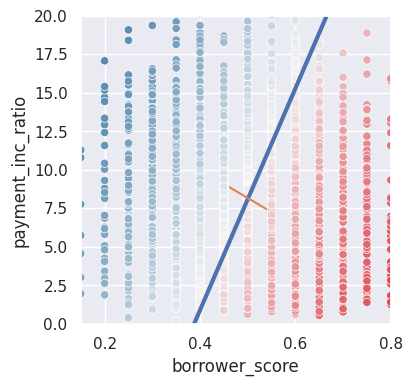

In [8]:
# Use scalings and center of means to determine decision boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                hue='default', data=lda_df,
                palette=sns.diverging_palette(10, 240, n=9, as_cmap=True),
                ax=ax, legend=False)
ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())
plt.show()

Above plot of the predictions helps illustrate how LDA works. Data points on the left of the diagonal line are predicted to default (probability greater than 0.5).

Using the discriminant function weights, LDA splits the predictor space into two regions, as shown by the solid line. The predictions farther away from the line in both directions have a higher level of confidence.

## 5.3 Logistic Regression

Logistic regression is analogous to multiple linear regression, except the outcome is binary.

#### <center>Key Terms for Logistic Regression</center>
- ***Logit***  
The function that maps class membership probability to a range from ± ∞ (instead of 0 to 1).<br>  
*Synonym*
    - Log odds (see below)
- ***Odds***  
The ratio of “success” (1) to “not success” (0).
- ***Log odds***  
The response in the transformed model (now linear), which gets mapped back to a probability.

### Logistic Response Function and Logit
$$\begin{aligned}
& p = \frac{1}{1+e^{-(\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q)}} \\
& Odds(Y=1) = \frac{p}{1-p} \\
& p = \frac{Odds}{1+Odds} \\
& Odds(Y=1) = e^{\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q} \\
& \log{(Odds(Y=1))} = \beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_qx_q
\end{aligned}$$

The *log-odds* function, also known as the *logit* function, maps the probability *p* from (0, 1) to any value (− ∞, + ∞)

### Logistic Regression

Below is an example to build a logistic regression model for loan data `outcome`

In [9]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                   drop_first=True)
y = loan_data[outcome]

logit_reg = LogisticRegression()
logit_reg.fit(X, y)

LogisticRegression()

Below code shows the fitting coefficients.  
- These coefficients are used to calculate the log-odds of the first prediction class `default`

In [10]:
pd.Series(
    logit_reg.intercept_.tolist() + logit_reg.coef_.tolist()[0],
    ['Intercept'] + logit_reg.feature_names_in_.tolist(),
    name = 'Coefficient'
).to_frame()

,Coefficient
Intercept,-1.620971
payment_inc_ratio,-0.079564
borrower_score,4.579133
debt_consolidation,-0.248960
home_improvement,-0.401284
major_purchase,-0.226736
medical,-0.516146
other,-0.617134
small_business,-1.208105
OWN,-0.049367


We can make prediction using the model as below. The prediction is based on > 0.5 `predict_proba`, which is the default. In practice, a lower cutoff is often appropriate if the goal is to identify members of a rare class.

In [11]:
predict_proba = pd.DataFrame(logit_reg.predict_proba(X),
                             columns=logit_reg.classes_)
predict = pd.Series(logit_reg.predict(X), name='prediction')
pd.concat((predict_proba, predict), axis=1).head()

,default,paid off,prediction
0,0.243163,0.756837,paid off
1,0.315610,0.684390,paid off
2,0.516636,0.483364,default
3,0.587866,0.412134,default
4,0.458468,0.541532,paid off


## 5.4 Evaluating Classification Models

#### <center>Key Terms for Evaluating Classification Models</center>
- ***Accuracy***  
The percent (or proportion) of cases classified correctly.
- ***Confusion matrix***  
A tabular display (2×2 in the binary case) of the record counts by their predicted and actual classification status.
- ***Sensitivity***  
The percent (or proportion) of all 1s that are correctly classified as 1s.<br>  
*Synonym*
    - Recall
- ***Specificity***  
The percent (or proportion) of all 0s that are correctly classified as 0s.
- ***Precision***  
The percent (proportion) of predicted 1s that are actually 1s.
- ***ROC curve***  
A plot of sensitivity versus specificity.
- ***Lift***  
A measure of how effective the model is at identifying (comparatively rare) 1s at different probability cutoffs.

### Accuracy

$$\text{accuracy}=\frac{\sum \text{TruePositive}+\sum \text{TrueNegative}}{\text{SampleSize}}$$

In [12]:
accuracy = metrics.accuracy_score(
    y == 'default',
    logit_reg.predict(X) == 'default'
)
print(f'accuracy = {accuracy}')

accuracy = 0.636341581756429


Accuracy is NOT a perfect metric suitable to all cases. For example, if only 0.1% of the browsers at a web store end up purchasing, a model that predicts that each browser will leave without purchasing will be 99.9% accurate. However, it will be useless. Instead, we would be happy with a model that is less accurate overall but is good at picking out the purchasers, even if it misclassifies some nonpurchasers along the way.

### Confusion Matrix

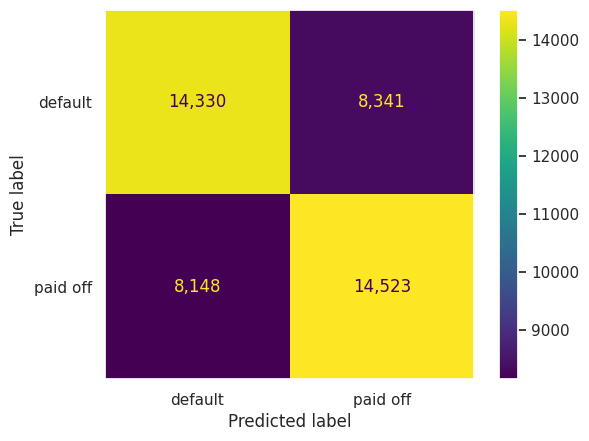

In [13]:
confusion_matrix = metrics.confusion_matrix(
    y, logit_reg.predict(X),
    labels = logit_reg.classes_
)
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix,
    display_labels = logit_reg.classes_
)
display.plot(values_format=',d')
plt.grid()
plt.show()

### Precision, Recall, and F-score

F-score (F1 score) is the harmonic mean of precision and recall:
$$F_1=\frac{2}{\text{recall}^{-1}+\text{precision}^{-1}}=
2\frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}}$$

In [14]:
pd.DataFrame(
    metrics.precision_recall_fscore_support(
        y, logit_reg.predict(X),
        labels = logit_reg.classes_
    ),
    index=['precision', 'recall', 'f_score', 'support'],
    columns=logit_reg.classes_
)


,default,paid off
precision,0.637512,0.635191
recall,0.632085,0.640598
f_score,0.634787,0.637883
support,22671.000000,22671.000000


### ROC Curve & AUC Score

You can see that there is a trade-off between recall and specificity. Capturing more 1s generally means misclassifying more 0s as 1s. The ideal classifier would do an excellent job of classifying the 1s, without misclassifying more 0s as 1s.

The metric that captures this trade-off is the “Receiver Operating Characteristics” curve, usually referred to as the *ROC curve*.

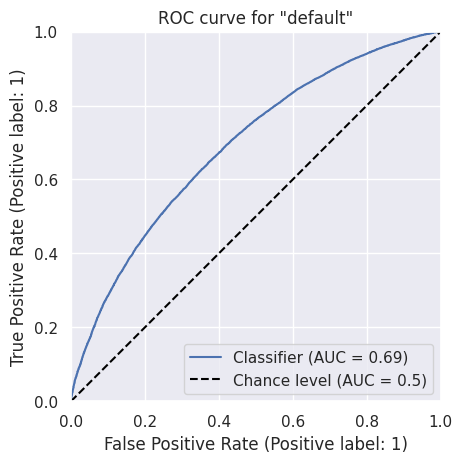

In [15]:
metrics.RocCurveDisplay.from_predictions(
    y == 'default',
    logit_reg.predict_proba(X)[:,0],
#     plot_chance_level = True
)
plt.axline((0, 0), (1, 1), ls='--', color='black', label='Chance level (AUC = 0.5)')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('ROC curve for "default"')
plt.show()

The area underneath the curve (AUC) is a metric showing the effectiveness of the classifier. An AUC of 1 indicates a perfect classifier. A completely ineffective classifier (the diagonal line) wil have an AUC of 0.5.

### Lift

Using the AUC as a metric to evaluate a model is an improvement over simple accuracy, as it can assess how well a classifier handles the trade-off between overall accuracy and the need to identify the more important 1s. But it does not completely address the rare-case problem, where you need to lower the model’s probability cutoff below 0.5 to avoid having all records classified as 0. In such cases, for a record to be classified as a 1, it might be sufficient to have a probability of 0.4, 0.3, or lower. In effect, we end up overidentifying 1s, reflecting their greater importance.

Changing this cutoff will improve your chances of catching the 1s (at the cost of misclassifying more 0s as 1s). But what is the optimum cutoff?

The concept of lift lets you defer answering that question. Instead, you consider the records in order of their predicted probability of being 1s. Say, of the top 10% classified as 1s, how much better did the algorithm do, compared to the benchmark of simply picking blindly? If you can get 0.3% response in this top decile instead of the 0.1% you get overall by picking randomly, the algorithm is said to have a *lift* (also called *gains*) of 3 in the top decile. A lift chart (gains chart) quantifies this over the range of the data. It can be produced decile by decile, or continuously over the range of the data.

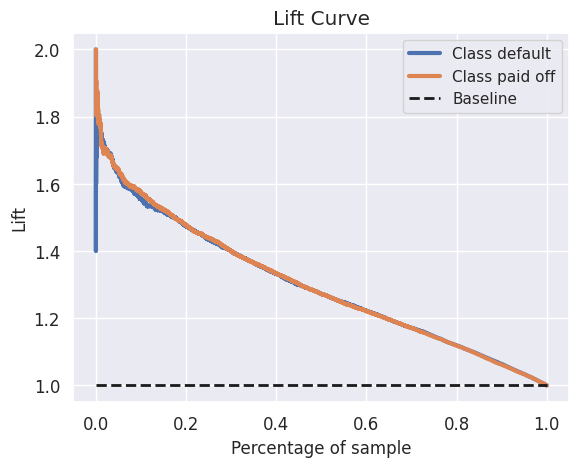

In [16]:
skplt.metrics.plot_lift_curve(
    y_true=y, 
    y_probas=logit_reg.predict_proba(X)
)
plt.legend(loc='upper right')
plt.show()

## 5.5 Strategies for Imbalanced Data

#### <center>Key Terms for Imbalanced Data</center>
- ***Undersample***  
Use fewer of the prevalent class records in the classification model.<br>  
*Synonym*
    - Downsample
- ***Oversample***  
Use more of the rare class records in the classification model, bootstrapping if necessary.<br>  
*Synonym*
    - Upsample
- ***Up weight or down weight***  
Attach more (or less) weight to the rare (or prevalent) class in the model.
- ***Data generation***  
Like bootstrapping, except each new bootstrapped record is slightly different from its source.
- ***z-score***  
The value that results after standardization.
- ***K***  
The number of neighbors considered in the nearest neighbor calculation.

### Undersampling

Previous `loan_data` is downsampled from full data set so that the numbers of 'default' and 'paid off' are equal. The model we built also predict roughly 50% of the loans to be in default.

In the full data set, only about 19% of the loans were in default:

In [17]:
print('percentage of loans in default: ' + 
      f'{np.mean(full_train_set.outcome == "default"):.2%}')

percentage of loans in default: 18.89%


What happens if we use the full data set to train the model?

In [18]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='',
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression()
full_model.fit(X, y)

print('percentage of loans predicted to default: ' +
      f"{np.mean(full_model.predict(X) == 'default'):.2%}")

percentage of loans predicted to default: 0.88%


Only 0.88% of the loans are predicted to be in default, or less than 1/21 of the expected number.

This is the effect of imbalanced data.

### Oversampling and Up/Down Weighting

One criticism of the undersampling method is that it throws away data and is not using all the information at hand. If you have a relatively small data set, and the rarer class contains a few hundred or a few thousand records, then undersampling the dominant class has the risk of throwing out useful information. In this case, instead of downsampling the dominant case, you should oversample (upsample) the rarer class by drawing additional rows with replacement (bootstrapping).

You can achieve a similar effect by weighting the data. Many classification algorithms take a weight argument that will allow you to up/down weight the data.

In [19]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
paid_wt = 1 / np.mean(full_train_set.outcome == 'paid off')
wt = [default_wt if outcome == 'default' else paid_wt
      for outcome in full_train_set.outcome]

full_model = LogisticRegression()
full_model.fit(X, y, sample_weight=wt)
print('percentage of loans predicted to default (weighting): ' +
      f"{np.mean(full_model.predict(X) == 'default'):.2%}")

percentage of loans predicted to default (weighting): 44.07%


The sums of the weights for the defaulting loans and nondefaulting loans are equal. Th mean of the predicted value is now abtout 44% instead of 0.88%.

### Data Generation

A variation of upsampling via bootstrapping is *data generation* by perturbing existing records to create new records. The intuition behind this idea is that since we observe only a limited set of instances, the algorithm doesn’t have a rich set of information to build classification “rules.” By creating new records that are similar but not identical to existing records, the algorithm has a chance to learn a more robust set of rules. This notion is similar in spirit to ensemble statistical models such as boosting and bagging.

The idea gained traction with the publication of the *SMOTE* algorithm, which stands for “Synthetic Minority Oversampling Technique.” The SMOTE algorithm finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighboring record, where the weight is generated separately for each predictor. The number of synthetic oversampled records created depends on the oversampling ratio required to bring the data set into approximate balance with respect to outcome classes.

### Cost-Based Classification

Once we have the ROC of a classifier, how to choose the best cutoff value? Often, an estimated cost can be assigned to false positives versus false negatives, and it is more appropriate to incorporate these costs to determine the best cutoff when classifying 1s and 0s. So the task of finding the best cutoff is reduced to minimize cost of maximize return.